In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) tWhat gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def install_packages():
    !pip install -U openmim
    !mim install mmengine 
    !mim install "mmcv>=2.0.0" 

    !git clone -b main https://github.com/open-mmlab/mmsegmentation.git
    %cd mmsegmentation
    !pip install -v -e . 
    
install_packages()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.7 MB/s eta 0:00:00
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 17.5 MB/s eta 0:00:00
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/opt/conda/lib/python3.7/site-packages/setuptools/command/instal

In [3]:
# define directory paths to reference later

train_dir = '/kaggle/input/vesuvius-challenge-ink-detection/train/'
test_dir = '/kaggle/input/vesuvius-challenge-ink-detection/test/'

fragment_ids = ['1']
z_start = 20
z_dim = 5
size = 512

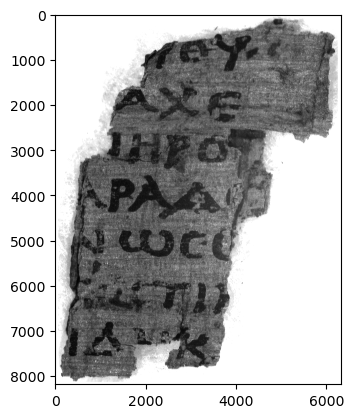

In [4]:
# plot the first fragment infrared scan

import matplotlib.pyplot as plt
import PIL.Image as Image

plt.imshow(Image.open(train_dir + '1/ir.png'), cmap='gray')

In [5]:
# import libraries, define device type

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from mmseg.structures import SegDataSample
from mmengine.structures import PixelData
from mmengine.runner import Runner

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

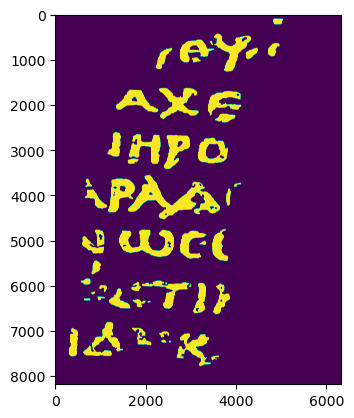

In [6]:
# example plot for the labels of the first fragment
label = np.array(Image.open(train_dir+"/1/inklabels.png"))
plt.imshow(label)

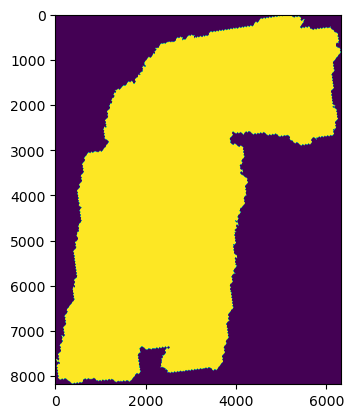

In [7]:
# only some pixels contain useful data - the mask contains the indices of these pixels
# plot these pixels for the first fragment
mask = Image.open(train_dir + '1/mask.png')
mask = np.array(mask)
plt.imshow(mask)

In [8]:
def get_indices(full_img, patch, size=size):
    """
    full_img - numpy array, should be the mask of useful pixels for a particular fragment
    size - int, desired input size for the model
    
    baseline approach - given an input size, reduce a full scan into non-overlapping
    subscans of the desired size.  Discards any extra pixels, discards any subscan 
    without at least one useful pixel.  
    
    Using this method, returns a list of indices of 
    the form (i, j) which can be used to slice a full scan by taking size*i:size*(i+1)
    and size*j:size*(j+1) respectively. 
    """
    lenx, leny = full_img.shape[0], full_img.shape[1]
    train_indices = []
    valid_indices = []
    for i in range(lenx // size):
        for j in range(leny // size):
            i1, i2, j1, j2 = [size*x for x in [i, i+1, j, j+1]]
            img = full_img[i1:i2, j1:j2]
            if img.sum() > 0:
                x_inside = (i2 > patch[0] and i2 < patch[1]) or (i1 < patch[1] and i1 > patch[0])
                y_inside = (j2 > patch[2] and j2 < patch[3]) or (j1 < patch[3] and j1 > patch[2])
                if x_inside or y_inside:
                    valid_indices.append((i, j))
                else: 
                    train_indices.append((i, j))
    return train_indices, valid_indices

In [9]:
def load_images(fragment_id, z_start, z_dim, train=True):
    """
    fragment_id - string, desired fragment to load
    z_start - int, specifies starting point for loading scans
    z_dim - int, number of scans to load from z_start

    Returns a list of scans starting from z=z_start to z=z_dim for a particular fragment_id
    """
        
    if train:
        path = train_dir + f'/{fragment_id}/surface_volume/*.tif'
    else:
        path = test_dir + f'/{fragment_id}/surface_volume/*.tif'
    images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename \
          in tqdm(sorted(glob.glob(path))[z_start:z_start+z_dim])]
    return images

In [10]:
class VesuviusDATASET(data.Dataset):
    def __init__(self, fragment_ids, indices, z_start, z_dim, size=size, train=True):
        self.size = size
        self.image_indices = []
        self.labels = []
        self.metainfo = {'classes':['ink', 'no_ink']}
        
        for fragment_id in fragment_ids:
            for scan_no in range(len(fragment_scans[fragment_id])):
                self.image_indices.extend([x for x in indices])
            self.labels.extend([(fragment_id, x) for x in indices])

    def __getitem__(self, index):
        fragment_id, scan_no, (i, j) = self.image_indices[index]
        
        image = fragment_scans[fragment_id][scan_no]
        image = image[self.size*i:self.size*(i+1), self.size*j:self.size*(j+1)]
        image = image.reshape(1, self.size, self.size)
        image = torch.tensor(image)
        
        label = fragment_labels[fragment_id]
        label = label[self.size*i:self.size*(i+1), self.size*j:self.size*(j+1)]
        label = label.reshape(1, self.size, self.size)
        
        img_meta = dict(img_shape = (512, 512), pad_shape = (1, 512, 512), ori_shape = (512, 512))
        segmentations = PixelData(metainfo=img_meta)
        segmentations.data = torch.tensor(label)
        data_sample = SegDataSample(metainfo=img_meta)
        data_sample.gt_sem_seg = segmentations
        
        return image, data_sample
    
    def __len__(self):
        return len(self.image_indices)

In [11]:
def collate(data):
    images = torch.stack([sample[0] for sample in data])
    data_samples = [sample[1] for sample in data]
    data = {'inputs':images, 'data_samples':data_samples}
    return data

In [12]:
from tqdm import tqdm
import glob

In [13]:
fragment_scans, fragment_labels = {}, {}
train_indices = []
valid_indices = []

# todo: add code to use different patches for different fragments
patch = (1300, 1600, 3800, 4100)

# not implemented yet - for future validation split
# fragment_image_indexes = []
for fragment_id in fragment_ids:
    path = train_dir + f'/{fragment_id}/'
    fragment_labels[fragment_id] = np.array(Image.open(path+"inklabels.png"))
    fragment_scans[fragment_id] = load_images(fragment_id, z_start, z_dim)
    mask = Image.open(path + 'mask.png')
    mask = np.array(mask)
    train_fragment_indices, valid_fragment_indices = get_indices(mask, patch)
    for scan_no in range(len(fragment_scans[fragment_id])):
        tr_idx = [[fragment_id, scan_no, x] for x in train_fragment_indices]
        train_indices.extend(tr_idx)
        val_idx = [[fragment_id, scan_no, x] for x in valid_fragment_indices]
        valid_indices.extend(val_idx)
        
        # not implemented yet - for future validation split 
        # fragment_image_indexes.append(len(idx))


train_dataset = VesuviusDATASET(fragment_ids, train_indices, z_start, z_dim)
valid_dataset = VesuviusDATASET(fragment_ids, valid_indices, z_start, z_dim)

train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=64, shuffle=True, collate_fn=collate)

100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


<Figure size 1200x1200 with 0 Axes>

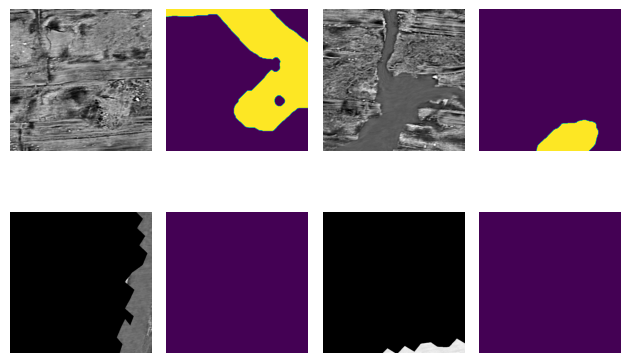

In [14]:
data_samples = next(iter(train_dataloader))
images = data_samples['inputs'][:4]
labels = torch.stack([data_samples['data_samples'][i].gt_sem_seg.data for i in range(4)])
images, labels = images[:4].view(4, 512, 512), labels[:4].view(4, 512, 512)

plt.figure(figsize=(12, 12))

fig, ax = plt.subplots(2, 4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i < 2:
        ax[0][2*i].imshow(image, cmap='gray')
        ax[0][2*i+1].imshow(label)
        ax[0][2*i].axis('off'), ax[0][2*i+1].axis('off')
    else:
        i -= 2
        ax[1][2*i].imshow(image, cmap='gray')
        ax[1][2*i+1].imshow(label)
        ax[1][2*i].axis('off'), ax[1][2*i+1].axis('off')
plt.tight_layout()

https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb

https://github.com/open-mmlab/mmsegmentation/blob/master/configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py


In [15]:
#!mim download mmsegmentation --config swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512 --dest .
!mim download mmsegmentation --config swin-small-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512 --dest .

processing swin-small-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.6/310.6 MiB 40.6 MB/s eta 0:00:00
Successfully downloaded upernet_swin_small_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210526_192015-ee2fff1c.pth to /kaggle/working/mmsegmentation
Successfully dumped swin-small-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py to /kaggle/working/mmsegmentation


In [16]:
from mmengine import Config

In [17]:
import shutil
def clear_working_dir():
    for x in os.listdir('/kaggle/working/'):
        try:
            if x == 'mmsegmentation':
                continue
            if x[-2:] == 'py':
                os.remove('/kaggle/working/' + x)
            else:
                shutil.rmtree('/kaggle/working/' + x)
        except NotADirectoryError:
            pass

In [18]:
#config_file = 'swin-tiny-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py'
config_file = 'swin-small-patch4-window7-in1k-pre_upernet_8xb2-160k_ade20k-512x512.py'
cfg = Config.fromfile(config_file)

In [19]:
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=96,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.

In [20]:
cfg.model.backbone.in_channels = 1
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2
cfg.model.decode_head.out_channels = 1
cfg.model.decode_head.loss_decode.use_sigmoid = True
cfg.model.auxiliary_head.out_channels = 1
cfg.model.auxiliary_head.loss_decode.use_sigmoid = True

In [21]:
if device.type == 'cpu':
    cfg.model.decode_head.norm_cfg.type = 'BN'
    cfg.model.auxiliary_head.norm_cfg.type = 'BN'
    cfg.norm_cfg.type = 'BN'

In [22]:
from mmseg.apis import init_model, show_result_pyplot
import mmcv

model = init_model(cfg, device=device)
model.data_preprocessor._enable_normalize = False

/kaggle/working/mmsegmentation/mmseg/models/decode_heads/decode_head.py:136: UserWarning: threshold is not defined for binary, and defaultsto 0.3
  warnings.warn('threshold is not defined for binary, and defaults'
/kaggle/working/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/kaggle/working/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


In [23]:
from mmseg.models import SegDataPreProcessor
from numbers import Number
from typing import Any, Dict, List, Optional, Sequence

import torch

from mmseg.registry import MODELS
from mmseg.utils import stack_batch

class DataPreProcessor(SegDataPreProcessor):
    def __init__(self, size):
        super().__init__(size=size)
    
    def forward(self, data: dict, training: bool = False) -> Dict[str, Any]:
        """Edited to allow for batch validation.
        
        Perform normalization、padding and bgr2rgb conversion based on
        ``BaseDataPreprocessor``.
        Args:
            data (dict): data sampled from dataloader.
            training (bool): Whether to enable training time augmentation.
        Returns:
            Dict: Data in the same format as the model input.
        """
        data = self.cast_data(data)  # type: ignore
        inputs = data['inputs']
        data_samples = data.get('data_samples', None)
        # TODO: whether normalize should be after stack_batch
        if self.channel_conversion and inputs[0].size(0) == 3:
            inputs = [_input[[2, 1, 0], ...] for _input in inputs]

        inputs = [_input.float() for _input in inputs]
        if self._enable_normalize:
            inputs = [(_input - self.mean) / self.std for _input in inputs]

        if training:
            assert data_samples is not None, ('During training, ',
                                              '`data_samples` must be define.')
            inputs, data_samples = stack_batch(
                inputs=inputs,
                data_samples=data_samples,
                size=self.size,
                size_divisor=self.size_divisor,
                pad_val=self.pad_val,
                seg_pad_val=self.seg_pad_val)

            if self.batch_augments is not None:
                inputs, data_samples = self.batch_augments(
                    inputs, data_samples)
        else:
            # pad images when testing
            if self.test_cfg:
                inputs, padded_samples = stack_batch(
                    inputs=inputs,
                    size=self.test_cfg.get('size', None),
                    size_divisor=self.test_cfg.get('size_divisor', None),
                    pad_val=self.pad_val,
                    seg_pad_val=self.seg_pad_val)
                for data_sample, pad_info in zip(data_samples, padded_samples):
                    data_sample.set_metainfo({**pad_info})
            else:
                inputs = torch.stack(inputs, dim=0)

        return dict(inputs=inputs, data_samples=data_samples)


model.data_preprocessor = DataPreProcessor(size=(512, 512))

In [24]:
valid_dataset = VesuviusDATASET(fragment_ids, valid_indices, z_start, z_dim)

In [25]:
train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate)
val_dataloader = data.DataLoader(valid_dataset, batch_size=8, shuffle=True, collate_fn=collate)

In [26]:
 default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=1, log_metric_by_epoch=False),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=16000),
)

In [27]:
from mmengine.registry import MODELS, DATASETS, METRICS
from mmengine.evaluator import BaseMetric
from mmseg.evaluation.metrics.iou_metric import IoUMetric

#METRICS.register_module(module=IoUMetric)

@METRICS.register_module()
class F05Score(BaseMetric):
    """
    Metric for computing the F0.5 Score.  Passed to the runner in the cfg["val_evaluator"].
    Init arguments can be passed by adding keys to the cfg["val_evaluator"] dict.  
    May return nan if all variables in precision or recall functions are 0, unlikely since the
    score is calculated over an entire validation run.  Occurs if either both true positives
    and false positives or true positives and false negatives are both 0.  Likely caused by some
    images having essentially no ink labels or all ink labels, and an initial model may predict
    mostly one label.
    """
    def __init__(self):
        super().__init__()
    
    def process(self, data_batch, data_samples):
        for data_sample in data_samples:
            pred_label = data_sample['pred_sem_seg']['data'].squeeze()
            label = data_sample['gt_sem_seg']['data'].squeeze()
            self.results.append(self.calculate_f05score(pred_label, label))
            
    def compute_metrics(self, results):
        results = tuple(zip(*results))
        assert len(results) == 3
        tp = sum(results[0])
        fp = sum(results[1])
        fn = sum(results[2])
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        
        score = ((1 + 0.5**2)*precision*recall) / ((0.5**2)*precision+recall)
        metrics = {'F05 Score':score}
        
        return metrics
    
    def calculate_f05score(self, pred_label, label):
        pred_label, label = pred_label.view(512*512), label.view(512*512)
        tp = ((pred_label==1) * (label==1)).sum()
        fp = ((pred_label==1) * (label==0)).sum()
        fn = ((pred_label==0) * (label==1)).sum()

        return tp, fp, fn


In [28]:
cfg['train_cfg']['val_interval'] = 20
cfg['train_cfg']['max_iters'] = 400

In [29]:
cfg['val_cfg'] = {'type':'ValLoop'}

In [30]:
cfg['val_evaluator'] = dict(type='F05Score')

In [31]:
import gc; gc.collect()

84

In [32]:
cfg['optim_wrapper']['optimizer']['lr'] = 6e-06

In [33]:
runner = Runner(model, work_dir='/kaggle/working/', 
                train_dataloader=train_dataloader, 
                train_cfg=cfg['train_cfg'],
                val_dataloader=val_dataloader,
                val_cfg=cfg['val_cfg'],
                val_evaluator=cfg['val_evaluator'], 
                optim_wrapper=cfg['optim_wrapper'],
                default_hooks=default_hooks)

05/07 02:44:19 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1752304848
    GPU 0: Tesla P100-PCIE-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.13.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.4
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2022.1-Product Build 20220311 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-ge

In [34]:
runner.train()

05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=6e-06
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:weight_decay=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:decay_mult=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:lr=6e-06
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:weight_decay=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.bias:decay_mult=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:lr=6e-06
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:weight_decay=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backbone.stages.0.blocks.0.norm1.weight:decay_mult=0.0
05/07 02:44:19 - mmengine - INFO - paramwise_options -- backb

EncoderDecoder(
  (data_preprocessor): DataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (nor